# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [6]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.394207
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** 因为w随机初始化，所以每个类计算的得分是相同的，经过softmax之后的概率是一样的，而这是一个10分类的问题，因此每一个类的概率都是0.1，求得交叉熵也就是-log(0.1)


In [22]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.104760 analytic: -1.104760, relative error: 1.254446e-08
numerical: 2.120623 analytic: 2.120623, relative error: 3.447641e-08
numerical: -5.384522 analytic: -5.384522, relative error: 6.037380e-09
numerical: -1.082815 analytic: -1.082815, relative error: 4.261545e-08
numerical: 0.261080 analytic: 0.261079, relative error: 2.341161e-07
numerical: 3.615435 analytic: 3.615435, relative error: 5.963828e-09
numerical: -4.202469 analytic: -4.202469, relative error: 1.272025e-08
numerical: 2.958773 analytic: 2.958773, relative error: 4.215239e-08
numerical: -4.104523 analytic: -4.104523, relative error: 1.435860e-08
numerical: -0.938492 analytic: -0.938492, relative error: 5.730473e-08
numerical: -1.652304 analytic: -1.652304, relative error: 2.623082e-08
numerical: -5.215290 analytic: -5.215290, relative error: 5.075250e-09
numerical: 0.379464 analytic: 0.379464, relative error: 8.274059e-08
numerical: -0.534305 analytic: -0.534305, relative error: 3.794812e-09
numerical: -3.26

In [23]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.394207e+00 computed in 0.059321s
vectorized loss: 2.394207e+00 computed in 0.007036s
Loss difference: 0.000000
Gradient difference: 0.000000


In [27]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 2e-7, 3e-7, 5e-5, 8e-7]
regularization_strengths = [1e4, 2e4, 2.5e4, 3e4, 4e4, 5e4, 6e4, 7e4, 1e5]
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
iters = 1500
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax_t = Softmax()
        softmax_t.train(X_train, y_train, 
                    learning_rate=lr, reg=reg,
                    num_iters=iters, verbose=True)
        
        y_train_pred = softmax_t.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        
        y_val_pred = softmax_t.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        # 给字典赋值
        results[(lr, reg)] = (acc_train, acc_val)

        if best_val < acc_val:
            best_val = acc_val
            best_softmax = softmax_t
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 158.312192
iteration 100 / 1500: loss 128.644626
iteration 200 / 1500: loss 105.346518
iteration 300 / 1500: loss 86.157713
iteration 400 / 1500: loss 70.609625
iteration 500 / 1500: loss 58.009332
iteration 600 / 1500: loss 47.745617
iteration 700 / 1500: loss 39.390885
iteration 800 / 1500: loss 32.501391
iteration 900 / 1500: loss 26.986494
iteration 1000 / 1500: loss 22.441380
iteration 1100 / 1500: loss 18.590450
iteration 1200 / 1500: loss 15.609723
iteration 1300 / 1500: loss 13.058506
iteration 1400 / 1500: loss 11.003978
iteration 0 / 1500: loss 312.771719
iteration 100 / 1500: loss 209.158935
iteration 200 / 1500: loss 140.257841
iteration 300 / 1500: loss 94.361474
iteration 400 / 1500: loss 63.691419
iteration 500 / 1500: loss 43.254557
iteration 600 / 1500: loss 29.666257
iteration 700 / 1500: loss 20.481977
iteration 800 / 1500: loss 14.337161
iteration 900 / 1500: loss 10.256427
iteration 1000 / 1500: loss 7.567424
iteration 1100 / 1500: loss 5.7

iteration 1300 / 1500: loss 2.125418
iteration 1400 / 1500: loss 2.073219
iteration 0 / 1500: loss 926.242399
iteration 100 / 1500: loss 84.088200
iteration 200 / 1500: loss 9.390670
iteration 300 / 1500: loss 2.779019
iteration 400 / 1500: loss 2.123394
iteration 500 / 1500: loss 2.156315
iteration 600 / 1500: loss 2.104365
iteration 700 / 1500: loss 2.128250
iteration 800 / 1500: loss 2.105316
iteration 900 / 1500: loss 2.097377
iteration 1000 / 1500: loss 2.158419
iteration 1100 / 1500: loss 2.096837
iteration 1200 / 1500: loss 2.093814
iteration 1300 / 1500: loss 2.084447
iteration 1400 / 1500: loss 2.056461
iteration 0 / 1500: loss 1072.392675
iteration 100 / 1500: loss 65.447039
iteration 200 / 1500: loss 5.900756
iteration 300 / 1500: loss 2.339407
iteration 400 / 1500: loss 2.151838
iteration 500 / 1500: loss 2.117388
iteration 600 / 1500: loss 2.079760
iteration 700 / 1500: loss 2.094806
iteration 800 / 1500: loss 2.127961
iteration 900 / 1500: loss 2.094001
iteration 1000 / 1

iteration 1200 / 1500: loss 142.811686
iteration 1300 / 1500: loss 156.063954
iteration 1400 / 1500: loss 159.974518
iteration 0 / 1500: loss 468.572878


/home/fantasy/Coursera_AI/CS231n/Assignments_Spring_2017/assignment1/cs231n/classifiers/softmax.py:88: RuntimeWarning: divide by zero encountered in log
  
/home/fantasy/Coursera_AI/CS231n/Assignments_Spring_2017/assignment1/cs231n/classifiers/softmax.py:88: RuntimeWarning: invalid value encountered in multiply
  


iteration 100 / 1500: loss nan
iteration 200 / 1500: loss 275.320834
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss 285.400541
iteration 700 / 1500: loss 258.255300
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss 273.595969
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss 272.729823
iteration 0 / 1500: loss 617.590544
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 776.237370
iteration 100 /

/home/fantasy/Coursera_AI/CS231n/Assignments_Spring_2017/assignment1/cs231n/classifiers/softmax.py:88: RuntimeWarning: overflow encountered in double_scalars
  
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/fantasy/Coursera_AI/CS231n/Assignments_Spring_2017/assignment1/cs231n/classifiers/softmax.py:88: RuntimeWarning: overflow encountered in multiply
  


iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 920.600580
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan


/home/fantasy/Coursera_AI/CS231n/Assignments_Spring_2017/assignment1/cs231n/classifiers/softmax.py:91: RuntimeWarning: overflow encountered in multiply
  # Initialize the loss and gradient to zero.
/home/fantasy/Coursera_AI/CS231n/Assignments_Spring_2017/assignment1/cs231n/classifiers/softmax.py:83: RuntimeWarning: invalid value encountered in subtract
  
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 1087.663259
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan


/home/fantasy/Coursera_AI/CS231n/Assignments_Spring_2017/assignment1/cs231n/classifiers/softmax.py:83: RuntimeWarning: overflow encountered in subtract
  


iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 1536.999077
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 158.143079
iteration 100 / 1500: loss 32.461944
iteration 200 / 1500: loss 7.983843
iteration 300 / 1500: loss 3.152011
iteration 400 / 1500: loss 2.139999
iteration 500 / 1500: loss 2.067071
iteration 600 / 1500: loss 1.902354
iteration 700 / 1500: loss 1.934950
iteration 800

In [28]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.366000


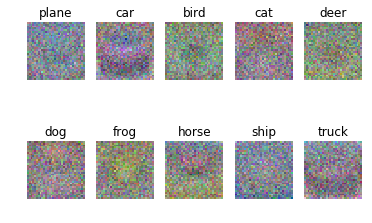

In [29]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])